# Setup

In [ ]:
pip install keras_tuner

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import pickle

In [ ]:

#connect google drive
from google.colab import drive
drive.mount('/content/drive')

#import csvs from google drive
trainPayments = pd.read_csv('/content/drive/MyDrive/Ecommerce_Order_Dataset/df_Payments.csv')
trainOrderItems = pd.read_csv('/content/drive/MyDrive/Ecommerce_Order_Dataset/df_OrderItems.csv')
trainCustomers = pd.read_csv('/content/drive/MyDrive/Ecommerce_Order_Dataset/df_Customers.csv')
trainProducts = pd.read_csv('/content/drive/MyDrive/Ecommerce_Order_Dataset/df_Products.csv')
trainOrders = pd.read_csv('/content/drive/MyDrive/Ecommerce_Order_Dataset/df_Orders.csv')


In [5]:
df = pd.concat([trainPayments, trainOrderItems, trainCustomers, trainProducts, trainOrders], axis=1)
df = df.T.drop_duplicates().T

# Data cleaning/preprocessing


In [6]:
#Get rid of unneeded data
df = df.drop(columns=['order_id', 'product_id', 'seller_id', 'customer_id', 'customer_zip_code_prefix', 'customer_city', 'order_status', 'order_approved_at', 'order_estimated_delivery_date'])

In [7]:
#drops rows with NAN values
df = df.dropna()

In [8]:
# Replace payment types with a vector that represents a certain payment type
payment_types = {'credit_card': 0, 'wallet': 1, 'voucher': 2, 'debit_card': 3}
x0 = []
for pay_type in list(df['payment_type']):
  pay_type_vector = [0,0,0,0]
  pay_type_vector[payment_types[pay_type]] = 1
  x0.append(pay_type_vector)
df['payment_type'] = x0

<ipython-input-8-253c1bb18c0d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['payment_type'] = x0


In [9]:
#Replace state with vector that represents state
customer_state = {
    'SP': 0, 'RJ': 1, 'MG': 2, 'SC': 3, 'ES': 4,
    'RN': 5, 'BA': 6, 'DF': 7, 'RS': 8, 'PE': 9,
    'GO': 10, 'CE': 11, 'PR': 12, 'MA': 13, 'PI': 14,
    'MT': 15, 'MS': 16, 'SE': 17, 'RO': 18, 'TO': 19,
    'AM': 20, 'AP': 21, 'PB': 22, 'PA': 23, 'AL': 24,
    'AC': 25, 'RR': 26
}
x1 = []
for state in list(df['customer_state']):
  customer_state_vector = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  customer_state_vector[customer_state[state]] = 1
  x1.append(customer_state_vector)
df['customer_state'] = x1

<ipython-input-9-4c2064dc037a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['customer_state'] = x1


In [10]:
# Put product categories into supercategories
home_and_living = [
    "furniture_decor",
    "bed_bath_table",
    "kitchen_dining_laundry_garden_furniture",
    "home_appliances",
    "home_comfort",
    "garden_tools",
    "housewares",
    "construction_tools_garden",
    "construction_tools_construction",
    "construction_tools_lights",
    "construction_tools_safety",
    "furniture_living_room",
    "furniture_bedroom",
    "furniture_mattress_and_upholstery"
]

fashion_and_accessories = [
    "fashion_shoes",
    "fashion_bags_accessories",
    "fashion_male_clothing",
    "fashio_female_clothing",
    "fashion_childrens_clothes",
    "fashion_underwear_beach",
    "fashion_sport"
]

toys_and_baby_products = [
    "toys",
    "baby",
    "diapers_and_hygiene"
]

health_and_beauty = [
    "health_beauty",
    "perfumery"
]

electronics_and_gadgets = [
    "audio",
    "computers_accessories",
    "computers",
    "consoles_games",
    "telephony",
    "small_appliances",
    "tablets_printing_image"
]

sports_and_leisure = [
    "sports_leisure"
]

food_and_beverages = [
    "food",
    "food_drink",
    "drinks"
]

arts_and_crafts = [
    "art",
    "arts_and_craftmanship"
]

gifts_and_celebrations = [
    "watches_gifts",
    "party_supplies",
    "christmas_supplies"
]

pets_and_animals = [
    "pet_shop"
]

office_and_stationery = [
    "office_furniture",
    "stationery"
]

industry_and_commerce = [
    "industry_commerce_and_business",
    "signaling_and_security",
    "agro_industry_and_commerce"
]

media_and_entertainment = [
    "books_technical",
    "books_general_interest",
    "books_imported",
    "dvds_blu_ray",
    "cine_photo",
    "music"
]

misc = [
    "cool_stuff"
]



cats0 = []

for cat in list(df['product_category_name']):
  if cat in home_and_living:
    cat = 'home_and_living'
  elif cat in fashion_and_accessories:
    cat = 'fashion_and_accessories'
  elif cat in toys_and_baby_products:
    cat = 'toys_and_baby_products'
  elif cat in health_and_beauty:
    cat = 'health_and_beauty'
  elif cat in electronics_and_gadgets:
    cat = 'electronics_and_gadgets'
  elif cat in sports_and_leisure:
    cat = 'sports_and_leisure'
  elif cat in food_and_beverages:
    cat = 'food_and_beverages'
  elif cat in arts_and_crafts:
    cat = 'arts_and_crafts'
  elif cat in gifts_and_celebrations:
    cat = 'gifts_and_celebrations'
  elif cat in pets_and_animals:
    cat = 'pets_and_animals'
  elif cat in office_and_stationery:
    cat = 'office_and_stationery'
  elif cat in industry_and_commerce:
    cat = 'industry_and_commerce'
  elif cat in media_and_entertainment:
    cat = 'media_and_entertainment'
  elif cat in misc:
    cat = 'misc'
  else:
    cat = 'misc'
  cats0.append(cat)

df['product_category_name'] = cats0

In [11]:
#Replace product category with vector representing the product category
prod_cat = {
    'home_and_living': 0,
    'fashion_and_accessories': 1,
    'toys_and_baby_products': 2,
    'health_and_beauty': 3,
    'electronics_and_gadgets': 4,
    'sports_and_leisure': 5,
    'food_and_beverages': 6,
    'arts_and_crafts': 7,
    'gifts_and_celebrations': 8,
    'pets_and_animals': 9,
    'office_and_stationery': 10,
    'industry_and_commerce': 11,
    'media_and_entertainment': 12,
    'misc': 13
}

x2 = []
for cat in list(df['product_category_name']):
  prod_cat_vec = [0 for i in range(14)]
  prod_cat_vec[prod_cat[cat]] = 1
  x2.append(prod_cat_vec)
df['product_category_name'] = x2

In [12]:
#Convert dimension measurements to volume
df['product_volume_cm^3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df = df.drop(columns=['product_length_cm', 'product_height_cm', 'product_width_cm'])

In [13]:
# Convert timestamps to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_timestamp'] = pd.to_datetime(df['order_delivered_timestamp'])

# Find difference
df['delivery_time'] = df['order_delivered_timestamp'] - df['order_purchase_timestamp']

# Convert to hours
df['delivery_time_days'] = df['delivery_time'].dt.total_seconds() / 86400

# Drop unnecessary columns
df.drop(columns=['order_purchase_timestamp', 'order_delivered_timestamp', 'delivery_time'], inplace=True)

In [14]:
# Delete outliers (delivery time is over ten days)
df = df[df['delivery_time_days'] <= 10]

In [15]:
payment_type = np.array(df['payment_type'].tolist())
payment_installments = np.array(df['payment_installments']).reshape(-1, 1)
shipping_charges = np.array(df['shipping_charges']).reshape(-1, 1)
customer_state = np.array(df['customer_state'].tolist())
product_category_name = np.array(df['product_category_name'].tolist())
product_weight = np.array(df['product_weight_g']).reshape(-1, 1)
product_volume = np.array(df['product_volume_cm^3']).reshape(-1, 1)

# Concatenate features
X = np.hstack([
    payment_type,
    payment_installments,
    shipping_charges,
    customer_state,
    product_category_name,
    product_weight,
    product_volume
])
X = X.astype(float)

# Convert target column to numpy array
y = np.array(df['delivery_time_days'])
y = y.astype(float)

In [16]:
# Shuffle data
X, y = shuffle(X, y, random_state=42)

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Heatmap

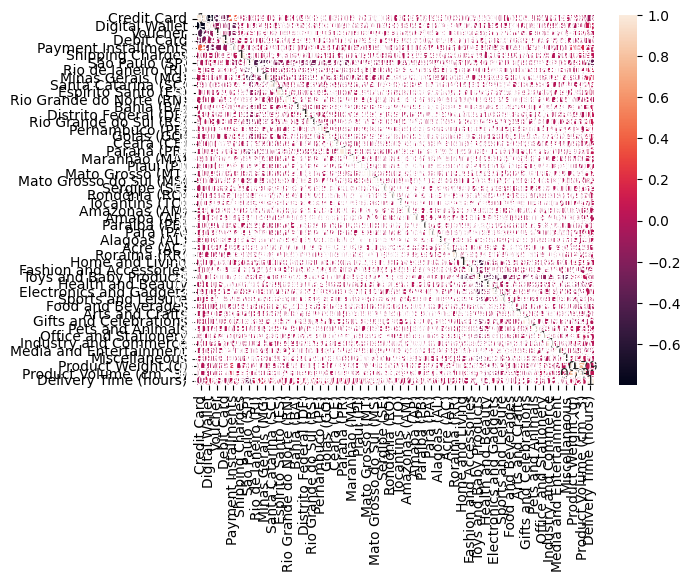

In [ ]:
# Create heatmap
columns = [
    'Credit Card',
    'Digital Wallet',
    'Voucher',
    'Debit Card',
    'Payment Installments',
    'Shipping Charges',
    'São Paulo (SP)',
    'Rio de Janeiro (RJ)',
    'Minas Gerais (MG)',
    'Santa Catarina (SC)',
    'Espírito Santo (ES)',
    'Rio Grande do Norte (RN)',
    'Bahia (BA)',
    'Distrito Federal (DF)',
    'Rio Grande do Sul (RS)',
    'Pernambuco (PE)',
    'Goiás (GO)',
    'Ceará (CE)',
    'Paraná (PR)',
    'Maranhão (MA)',
    'Piauí (PI)',
    'Mato Grosso (MT)',
    'Mato Grosso do Sul (MS)',
    'Sergipe (SE)',
    'Rondônia (RO)',
    'Tocantins (TO)',
    'Amazonas (AM)',
    'Amapá (AP)',
    'Paraíba (PB)',
    'Pará (PA)',
    'Alagoas (AL)',
    'Acre (AC)',
    'Roraima (RR)',
    'Home and Living',
    'Fashion and Accessories',
    'Toys and Baby Products',
    'Health and Beauty',
    'Electronics and Gadgets',
    'Sports and Leisure',
    'Food and Beverages',
    'Arts and Crafts',
    'Gifts and Celebrations',
    'Pets and Animals',
    'Office and Stationery',
    'Industry and Commerce',
    'Media and Entertainment',
    'Miscellaneous',
    'Product Weight (g)',
    'Product Volume (cm^3)',
    'Delivery Time (hours)'
]

data_corr = pd.DataFrame(np.hstack([X, np.expand_dims(y,-1)]), columns=columns).corr()

labels = data_corr.copy()

sns.heatmap(data_corr, annot=True, xticklabels=data_corr.columns, yticklabels=data_corr.columns)
sns.set(rc = {'figure.figsize':(50,35)})
plt.show()

# Models (No PCA)

In [ ]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def getMAE(model, X_val, y_val):
  total_diff = 0.0
  n_diff = 0.0
  for i in range(len(X_val)):
    total_diff += abs(model.predict(np.array([X_val[i]]))[0] - y_val[i])
    n_diff += 1
  return total_diff/n_diff

In [ ]:
def run_model(model_creation_func, model_fit_func, hyperparams, model_label, hyperparam_label):
  display = {'Model': [], 'MAE (# Days)': []}
  for param in tqdm(hyperparams):
    display['Model'].append(f"Model: {model_label} with {hyperparam_label} = {param}")
    mae = []
    model = model_creation_func(param)
    model = model_fit_func(model, X_train_scaled, y_train)
    mae.append(getMAE(model, X_test_scaled, y_test))
    display['MAE (# Days)'].append(np.mean(mae))

  display = pd.DataFrame(display)
  return display

In [ ]:
def make_xgb(max_depth):
  return xgb.XGBRegressor(max_depth=max_depth)

def fit_xgb(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
xgb_df = run_model(make_xgb, fit_xgb, range(1, 21), "XGBoost", "Max Depth")
xgb_df

100%|██████████| 20/20 [02:23<00:00,  7.15s/it]


,Model,MAE (# Days)
0,Model: XGBoost with Max Depth = 1,1.714198
1,Model: XGBoost with Max Depth = 2,1.674720
2,Model: XGBoost with Max Depth = 3,1.644962
3,Model: XGBoost with Max Depth = 4,1.620185
4,Model: XGBoost with Max Depth = 5,1.594405
5,Model: XGBoost with Max Depth = 6,1.561418
6,Model: XGBoost with Max Depth = 7,1.534541
7,Model: XGBoost with Max Depth = 8,1.509256
8,Model: XGBoost with Max Depth = 9,1.486310
9,Model: XGBoost with Max Depth = 10,1.450247


In [ ]:
def make_dt(max_depth):
  return DecisionTreeRegressor(max_depth=max_depth)

def fit_dt(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
dt_df = run_model(make_dt, fit_dt, range(1, 11), "Decision Tree", "Max Depth")
dt_df

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


,Model,MAE (# Days)
0,Model: Decision Tree with Max Depth = 1,1.774230
1,Model: Decision Tree with Max Depth = 2,1.757756
2,Model: Decision Tree with Max Depth = 3,1.743192
3,Model: Decision Tree with Max Depth = 4,1.734804
4,Model: Decision Tree with Max Depth = 5,1.704923
5,Model: Decision Tree with Max Depth = 6,1.692720
6,Model: Decision Tree with Max Depth = 7,1.677325
7,Model: Decision Tree with Max Depth = 8,1.665441
8,Model: Decision Tree with Max Depth = 9,1.656028
9,Model: Decision Tree with Max Depth = 10,1.656233


In [ ]:
def make_rf(max_depth):
  return RandomForestRegressor(max_depth=max_depth)

def fit_rf(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
rf_df = run_model(make_rf, fit_rf, range(1, 11), "Random Forest", "Max Depth")
rf_df

100%|██████████| 10/10 [05:02<00:00, 30.27s/it]


,Model,MAE (# Days)
0,Model: Random Forest with Max Depth = 1,1.774195
1,Model: Random Forest with Max Depth = 2,1.755283
2,Model: Random Forest with Max Depth = 3,1.739811
3,Model: Random Forest with Max Depth = 4,1.727685
4,Model: Random Forest with Max Depth = 5,1.700689
5,Model: Random Forest with Max Depth = 6,1.687228
6,Model: Random Forest with Max Depth = 7,1.667441
7,Model: Random Forest with Max Depth = 8,1.654025
8,Model: Random Forest with Max Depth = 9,1.635223
9,Model: Random Forest with Max Depth = 10,1.615639


In [ ]:
def make_knn(n_neighbors):
  return KNeighborsRegressor(n_neighbors=n_neighbors)

def fit_knn(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
knn_df = run_model(make_knn, fit_knn, range(1, 11), "K Nearest Neighbors", "N Neighbors")
knn_df

100%|██████████| 10/10 [03:15<00:00, 19.59s/it]


,Model,MAE (# Days)
0,Model: K Nearest Neighbors with N Neighbors = 1,1.765902
1,Model: K Nearest Neighbors with N Neighbors = 2,1.733732
2,Model: K Nearest Neighbors with N Neighbors = 3,1.723526
3,Model: K Nearest Neighbors with N Neighbors = 4,1.709808
4,Model: K Nearest Neighbors with N Neighbors = 5,1.702164
5,Model: K Nearest Neighbors with N Neighbors = 6,1.699691
6,Model: K Nearest Neighbors with N Neighbors = 7,1.705689
7,Model: K Nearest Neighbors with N Neighbors = 8,1.701716
8,Model: K Nearest Neighbors with N Neighbors = 9,1.703986
9,Model: K Nearest Neighbors with N Neighbors = 10,1.704449


In [ ]:
def make_svr(degree):
  return SVR(degree=degree)

def fit_svr(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
svr_df = run_model(make_svr, fit_svr, range(1, 11), "Support Vector Regression", "Degree")
svr_df

100%|██████████| 10/10 [22:17<00:00, 133.73s/it]


,Model,MAE (# Days)
0,Model: Support Vector Regression with Degree = 1,1.718487
1,Model: Support Vector Regression with Degree = 2,1.718487
2,Model: Support Vector Regression with Degree = 3,1.718487
3,Model: Support Vector Regression with Degree = 4,1.718487
4,Model: Support Vector Regression with Degree = 5,1.718487
5,Model: Support Vector Regression with Degree = 6,1.718487
6,Model: Support Vector Regression with Degree = 7,1.718487
7,Model: Support Vector Regression with Degree = 8,1.718487
8,Model: Support Vector Regression with Degree = 9,1.718487
9,Model: Support Vector Regression with Degree = 10,1.718487


# Models (PCA N Components = 35)

In [ ]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA N Components
PCA_n_components = 35

In [ ]:
def getMAE(model, X_val, y_val):
  total_diff = 0.0
  n_diff = 0.0
  for i in range(len(X_val)):
    total_diff += abs(model.predict(np.array([X_val[i]]))[0] - y_val[i])
    n_diff += 1
  return total_diff/n_diff

In [ ]:
def run_model(model_creation_func, model_fit_func, hyperparams, model_label, hyperparam_label, PCA_n_components, X_train_scaled, X_test_scaled):
  display = {'Model': [], 'MAE (# Days)': []}
  for param in tqdm(hyperparams):
    display['Model'].append(f"Model: {model_label} with {hyperparam_label} = {param}")
    mae = []
    pca = PCA(n_components=PCA_n_components)
    PCA_X_train = pca.fit_transform(X_train_scaled)
    PCA_X_test = pca.transform(X_test_scaled)
    model = model_creation_func(param)
    model = model_fit_func(model, PCA_X_train, y_train)
    mae.append(getMAE(model, PCA_X_test, y_test))
    display['MAE (# Days)'].append(np.mean(mae))

  display = pd.DataFrame(display)
  return display

In [ ]:
def make_xgb(max_depth):
  return xgb.XGBRegressor(max_depth=max_depth)

def fit_xgb(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
xgb_df = run_model(make_xgb, fit_xgb, range(1, 11), "XGBoost", "Max Depth", PCA_n_components, X_train_scaled, X_test_scaled)
xgb_df

100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


,Model,MAE (# Days)
0,Model: XGBoost with Max Depth = 1,1.721814
1,Model: XGBoost with Max Depth = 2,1.703360
2,Model: XGBoost with Max Depth = 3,1.683299
3,Model: XGBoost with Max Depth = 4,1.662152
4,Model: XGBoost with Max Depth = 5,1.643174
5,Model: XGBoost with Max Depth = 6,1.628499
6,Model: XGBoost with Max Depth = 7,1.596434
7,Model: XGBoost with Max Depth = 8,1.562363
8,Model: XGBoost with Max Depth = 9,1.551411
9,Model: XGBoost with Max Depth = 10,1.534410


In [ ]:
def make_dt(max_depth):
  return DecisionTreeRegressor(max_depth=max_depth)

def fit_dt(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
dt_df = run_model(make_dt, fit_dt, range(1, 11), "Decision Tree", "Max Depth", PCA_n_components, X_train_scaled, X_test_scaled)
dt_df

100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


,Model,MAE (# Days)
0,Model: Decision Tree with Max Depth = 1,1.769897
1,Model: Decision Tree with Max Depth = 2,1.756007
2,Model: Decision Tree with Max Depth = 3,1.734779
3,Model: Decision Tree with Max Depth = 4,1.722349
4,Model: Decision Tree with Max Depth = 5,1.708082
5,Model: Decision Tree with Max Depth = 6,1.701163
6,Model: Decision Tree with Max Depth = 7,1.687975
7,Model: Decision Tree with Max Depth = 8,1.684869
8,Model: Decision Tree with Max Depth = 9,1.690464
9,Model: Decision Tree with Max Depth = 10,1.681055


In [ ]:
def make_rf(max_depth):
  return RandomForestRegressor(max_depth=max_depth)

def fit_rf(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
rf_df = run_model(make_rf, fit_rf, range(1, 11), "Random Forest", "Max Depth", PCA_n_components, X_train_scaled, X_test_scaled)
rf_df

100%|██████████| 10/10 [16:39<00:00, 99.94s/it] 


,Model,MAE (# Days)
0,Model: Random Forest with Max Depth = 1,1.765927
1,Model: Random Forest with Max Depth = 2,1.750174
2,Model: Random Forest with Max Depth = 3,1.733238
3,Model: Random Forest with Max Depth = 4,1.716769
4,Model: Random Forest with Max Depth = 5,1.704137
5,Model: Random Forest with Max Depth = 6,1.693233
6,Model: Random Forest with Max Depth = 7,1.681127
7,Model: Random Forest with Max Depth = 8,1.668405
8,Model: Random Forest with Max Depth = 9,1.657719
9,Model: Random Forest with Max Depth = 10,1.645377


In [ ]:
def make_knn(n_neighbors):
  return KNeighborsRegressor(n_neighbors=n_neighbors)

def fit_knn(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
knn_df = run_model(make_knn, fit_knn, range(1, 11), "K Nearest Neighbors", "N Neighbors", PCA_n_components, X_train_scaled, X_test_scaled)
knn_df

100%|██████████| 10/10 [02:21<00:00, 14.18s/it]


,Model,MAE (# Days)
0,Model: K Nearest Neighbors with N Neighbors = 1,1.759194
1,Model: K Nearest Neighbors with N Neighbors = 2,1.729120
2,Model: K Nearest Neighbors with N Neighbors = 3,1.715878
3,Model: K Nearest Neighbors with N Neighbors = 4,1.701310
4,Model: K Nearest Neighbors with N Neighbors = 5,1.691996
5,Model: K Nearest Neighbors with N Neighbors = 6,1.698813
6,Model: K Nearest Neighbors with N Neighbors = 7,1.704169
7,Model: K Nearest Neighbors with N Neighbors = 8,1.701128
8,Model: K Nearest Neighbors with N Neighbors = 9,1.701768
9,Model: K Nearest Neighbors with N Neighbors = 10,1.697327


In [ ]:
def make_svr(degree):
  return SVR(degree=degree)

def fit_svr(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
svr_df = run_model(make_svr, fit_svr, range(1, 11), "Support Vector Regression", "Degree", PCA_n_components, X_train_scaled, X_test_scaled)
svr_df

100%|██████████| 10/10 [20:56<00:00, 125.69s/it]


,Model,MAE (# Days)
0,Model: Support Vector Regression with Degree = 1,1.718594
1,Model: Support Vector Regression with Degree = 2,1.718594
2,Model: Support Vector Regression with Degree = 3,1.718594
3,Model: Support Vector Regression with Degree = 4,1.718594
4,Model: Support Vector Regression with Degree = 5,1.718594
5,Model: Support Vector Regression with Degree = 6,1.718594
6,Model: Support Vector Regression with Degree = 7,1.718594
7,Model: Support Vector Regression with Degree = 8,1.718594
8,Model: Support Vector Regression with Degree = 9,1.718594
9,Model: Support Vector Regression with Degree = 10,1.718594


# Models (PCA N Components = 15)

In [ ]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA N Components
PCA_n_components = 15

In [ ]:
def getMAE(model, X_val, y_val):
  total_diff = 0.0
  n_diff = 0.0
  for i in range(len(X_val)):
    total_diff += abs(model.predict(np.array([X_val[i]]))[0] - y_val[i])
    n_diff += 1
  return total_diff/n_diff

In [ ]:
def run_model(model_creation_func, model_fit_func, hyperparams, model_label, hyperparam_label, PCA_n_components, X_train_scaled, X_test_scaled):
  display = {'Model': [], 'MAE (# Days)': []}
  for param in tqdm(hyperparams):
    display['Model'].append(f"Model: {model_label} with {hyperparam_label} = {param}")
    mae = []
    pca = PCA(n_components=PCA_n_components)
    PCA_X_train = pca.fit_transform(X_train_scaled)
    PCA_X_test = pca.transform(X_test_scaled)
    model = model_creation_func(param)
    model = model_fit_func(model, PCA_X_train, y_train)
    mae.append(getMAE(model, PCA_X_test, y_test))
    display['MAE (# Days)'].append(np.mean(mae))

  display = pd.DataFrame(display)
  return display

In [ ]:
def make_xgb(max_depth):
  return xgb.XGBRegressor(max_depth=max_depth)

def fit_xgb(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
xgb_df = run_model(make_xgb, fit_xgb, range(1, 11), "XGBoost", "Max Depth", PCA_n_components, X_train_scaled, X_test_scaled)
xgb_df

100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


,Model,MAE (# Days)
0,Model: XGBoost with Max Depth = 1,1.724871
1,Model: XGBoost with Max Depth = 2,1.703752
2,Model: XGBoost with Max Depth = 3,1.685497
3,Model: XGBoost with Max Depth = 4,1.670589
4,Model: XGBoost with Max Depth = 5,1.644355
5,Model: XGBoost with Max Depth = 6,1.618058
6,Model: XGBoost with Max Depth = 7,1.604968
7,Model: XGBoost with Max Depth = 8,1.578626
8,Model: XGBoost with Max Depth = 9,1.563999
9,Model: XGBoost with Max Depth = 10,1.549170


In [ ]:
def make_dt(max_depth):
  return DecisionTreeRegressor(max_depth=max_depth)

def fit_dt(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
dt_df = run_model(make_dt, fit_dt, range(1, 11), "Decision Tree", "Max Depth", PCA_n_components, X_train_scaled, X_test_scaled)
dt_df

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


,Model,MAE (# Days)
0,Model: Decision Tree with Max Depth = 1,1.769897
1,Model: Decision Tree with Max Depth = 2,1.754642
2,Model: Decision Tree with Max Depth = 3,1.737425
3,Model: Decision Tree with Max Depth = 4,1.725590
4,Model: Decision Tree with Max Depth = 5,1.710299
5,Model: Decision Tree with Max Depth = 6,1.705283
6,Model: Decision Tree with Max Depth = 7,1.697313
7,Model: Decision Tree with Max Depth = 8,1.691347
8,Model: Decision Tree with Max Depth = 9,1.698801
9,Model: Decision Tree with Max Depth = 10,1.704710


In [ ]:
def make_rf(max_depth):
  return RandomForestRegressor(max_depth=max_depth)

def fit_rf(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
rf_df = run_model(make_rf, fit_rf, range(1, 11), "Random Forest", "Max Depth", PCA_n_components, X_train_scaled, X_test_scaled)
rf_df

100%|██████████| 10/10 [09:28<00:00, 56.85s/it]


,Model,MAE (# Days)
0,Model: Random Forest with Max Depth = 1,1.765967
1,Model: Random Forest with Max Depth = 2,1.748713
2,Model: Random Forest with Max Depth = 3,1.733542
3,Model: Random Forest with Max Depth = 4,1.718196
4,Model: Random Forest with Max Depth = 5,1.705521
5,Model: Random Forest with Max Depth = 6,1.696024
6,Model: Random Forest with Max Depth = 7,1.683295
7,Model: Random Forest with Max Depth = 8,1.670075
8,Model: Random Forest with Max Depth = 9,1.660501
9,Model: Random Forest with Max Depth = 10,1.645925


In [ ]:
def make_knn(n_neighbors):
  return KNeighborsRegressor(n_neighbors=n_neighbors)

def fit_knn(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
knn_df = run_model(make_knn, fit_knn, range(1, 11), "K Nearest Neighbors", "N Neighbors", PCA_n_components, X_train_scaled, X_test_scaled)
knn_df

100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


,Model,MAE (# Days)
0,Model: K Nearest Neighbors with N Neighbors = 1,1.756742
1,Model: K Nearest Neighbors with N Neighbors = 2,1.737410
2,Model: K Nearest Neighbors with N Neighbors = 3,1.728805
3,Model: K Nearest Neighbors with N Neighbors = 4,1.702220
4,Model: K Nearest Neighbors with N Neighbors = 5,1.700432
5,Model: K Nearest Neighbors with N Neighbors = 6,1.689146
6,Model: K Nearest Neighbors with N Neighbors = 7,1.693345
7,Model: K Nearest Neighbors with N Neighbors = 8,1.689513
8,Model: K Nearest Neighbors with N Neighbors = 9,1.695596
9,Model: K Nearest Neighbors with N Neighbors = 10,1.696506


In [ ]:
def make_svr(degree):
  return SVR(degree=degree)

def fit_svr(model, X_train, y_train):
  return model.fit(X_train, y_train)

In [ ]:
svr_df = run_model(make_svr, fit_svr, range(1, 11), "Support Vector Regression", "Degree", PCA_n_components, X_train_scaled, X_test_scaled)
svr_df

100%|██████████| 10/10 [18:51<00:00, 113.13s/it]


,Model,MAE (# Days)
0,Model: Support Vector Regression with Degree = 1,1.715749
1,Model: Support Vector Regression with Degree = 2,1.715749
2,Model: Support Vector Regression with Degree = 3,1.715749
3,Model: Support Vector Regression with Degree = 4,1.715749
4,Model: Support Vector Regression with Degree = 5,1.715749
5,Model: Support Vector Regression with Degree = 6,1.715749
6,Model: Support Vector Regression with Degree = 7,1.715749
7,Model: Support Vector Regression with Degree = 8,1.715749
8,Model: Support Vector Regression with Degree = 9,1.715749
9,Model: Support Vector Regression with Degree = 10,1.715749


# Neural Networks


In [ ]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def build_nn(hp):
  layers = [Input(shape=(49,))]
  hp_num_layers = hp.Int('layer_count', min_value = 1, max_value = 10, step = 1)

  for i in range(hp_num_layers):
    hp_neurons = hp.Int(f'units{i+1}', min_value = 10, max_value = 160, step = 30)
    layers.append(Dense(units=hp_neurons, activation = 'relu'))

  layers.append(Dense(1, activation = 'linear'))

  model = Sequential(layers)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mae')

  return model

In [ ]:
tuner = kt.Hyperband(build_nn, objective = 'val_loss', max_epochs = 10,
  factor = 3, directory = 'ecommerce_tuning', project_name = 'tune_delivery_time')

In [ ]:
tuner.search(X_train_scaled, y_train, epochs=99, validation_data = (X_test_scaled, y_test))

optimal_hp_vals = tuner.get_best_hyperparameters(num_trials=1)[0]

best_num_neurons = []
for i in range(optimal_hp_vals.get('layer_count')):
  best_num_neurons.append(f"Hidden layer #{i+1}: {optimal_hp_vals.get(f'units{i+1}')}")

print(f"Best number of hidden layers: {optimal_hp_vals.get('layer_count')}",
      best_num_neurons,
      f"Best learning rate: {optimal_hp_vals.get('learning_rate')}", sep = '\n')

Best number of hidden layers: 10
['Hidden layer #1: 100', 'Hidden layer #2: 70', 'Hidden layer #3: 10', 'Hidden layer #4: 70', 'Hidden layer #5: 70', 'Hidden layer #6: 70', 'Hidden layer #7: 130', 'Hidden layer #8: 160', 'Hidden layer #9: 100', 'Hidden layer #10: 10']
Best learning rate: 0.001


In [ ]:
model = tuner.hypermodel.build(optimal_hp_vals)
history = model.fit(X_train_scaled, y_train, epochs=300, validation_data=(X_test_scaled, y_test))

val_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f'Best epoch: {best_epoch}', f'MAE: {min(val_loss_per_epoch)}', sep='\n')

Epoch 1/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.1607 - val_loss: 1.7557
Epoch 2/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.7723 - val_loss: 1.7366
Epoch 3/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7512 - val_loss: 1.7393
Epoch 4/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.7455 - val_loss: 1.7248
Epoch 5/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.7539 - val_loss: 1.7219
Epoch 6/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.7405 - val_loss: 1.7456
Epoch 7/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.7518 - val_loss: 1.7309
Epoch 8/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.7410 - val_loss: 1.7350
Epoch 9/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.7434 - val_loss: 1.7447
Epoch 10/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.7464 - val_loss: 1.7215
Epoch 11/300
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.7416 - val_loss: 1.7196
Epoch 12/300
1184/1

# Best Model

In [18]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
def getMAE(model, X_val, y_val):
  total_diff = 0.0
  n_diff = 0.0
  for i in range(len(X_val)):
    total_diff += abs(model.predict(np.array([X_val[i]]))[0] - y_val[i])
    n_diff += 1
  return total_diff/n_diff

In [21]:
model = xgb.XGBRegressor(max_depth=18)
model = model.fit(X_train_scaled, y_train)
mae = getMAE(model, X_test_scaled, y_test)

display = {"Model Error:": mae}
display

{'Model Error:': 1.3798879761503065}

In [30]:
pickle.dump(model, open('ecommerce_model.pckl', 'wb'))